# Import

In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
# project_id = "inner-arch-419406"
# query = """
# SELECT * FROM URA_data_transformed.rentals_for_BI;
# """
# df = pandas_gbq.read_gbq(query, project_id=project_id, dialect="standard")

df = pd.read_csv("../data/rental_data_for_BI.csv")

df

,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,psf75,median,psf25,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth
0,2021-07-03,Non-landed Properties,15,3,4200.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,1350.0,2021,3,7
1,2021-07-03,Non-landed Properties,15,2,3200.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,950.0,2021,3,7
2,2021-07-03,Non-landed Properties,15,3,5000.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,2150.0,2021,3,7
3,2021-07-03,Non-landed Properties,15,3,3500.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,1350.0,2021,3,7
4,2021-09-03,Non-landed Properties,15,4,5500.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,2650.0,2021,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281778,2023-12-04,Non-landed Properties,8,3,5500.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,650.0,2023,4,12
281779,2023-10-04,Non-landed Properties,8,2,4000.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,550.0,2023,4,10
281780,2023-10-04,Non-landed Properties,8,3,5300.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,750.0,2023,4,10
281781,2023-11-04,Non-landed Properties,8,2,4000.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,550.0,2023,4,11


# Data Pre-Processing

## Split Data into Landed and Non-landed

In [3]:
landed = df[(df["propertyType"] != "Non-landed Properties") & (df["propertyType"] != "Executive Condominium")].reset_index(drop=True) # Terrace House, Detached House, Semi-Detached House
nonlanded = df[(df["propertyType"] == "Non-landed Properties") | (df["propertyType"] == "Executive Condominium")].reset_index(drop=True) # landed Properties, Executive Condominium

## Data Imputation

In [4]:
EC_median_noOfBedRoom = np.median(nonlanded[(nonlanded["propertyType"] == "Executive Condominium") & (nonlanded["noOfBedRoom"] != -1)]["noOfBedRoom"])
nonlanded[(nonlanded["propertyType"] == "Executive Condominium")]["median"] = nonlanded[(nonlanded["propertyType"] == "Executive Condominium")]["median"].fillna(EC_median_noOfBedRoom)

In [5]:
nonlandedproperties_median_noOfBedRoom = np.median(nonlanded[(nonlanded["propertyType"] == "Non-landed Properties") & (nonlanded["noOfBedRoom"] != -1)]["noOfBedRoom"])
nonlanded[(nonlanded["propertyType"] == "Non-landed Properties")]["median"] = nonlanded[(nonlanded["propertyType"] == "Non-landed Properties")]["median"].fillna(nonlandedproperties_median_noOfBedRoom)

## One Hot Encoding

In [6]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)
print(landed_encoded.shape)
print(nonlanded_encoded.shape)

(20657, 42)
(261126, 42)


# Run on all features

## Landed

In [7]:
pprint(list(df.columns))

['leaseDate',
 'propertyType',
 'district',
 'noOfBedRoom',
 'rent',
 'street',
 'x',
 'y',
 'project',
 'refPeriod',
 'psf75',
 'median',
 'psf25',
 'areaSqft_formatted',
 'leaseYear',
 'leaseQuarter',
 'leaseMonth']


['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'district_2', 'district_3', 'district_4', 'district_5', 'district_7', 'district_8', 'district_9', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
'Tuned Hyperparameters:'
{'n_neighbors': 12, 'weights': 'distance'}
training r2: 0.7817761746822152
testing r2: 0.5194745117278241

score   = 0.5194745117278241
r2      = 0.5194745117278241
MAE     = 2648.1278235249447
RMSE    = 6224.398261323543
MSE     = 38743133.715567544
MAE %   = 0.27644625896166886



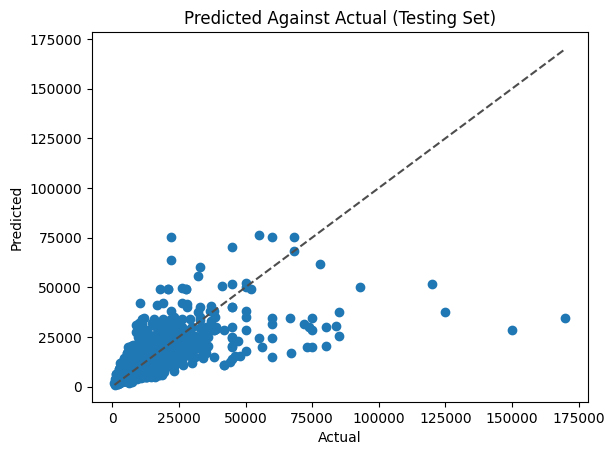

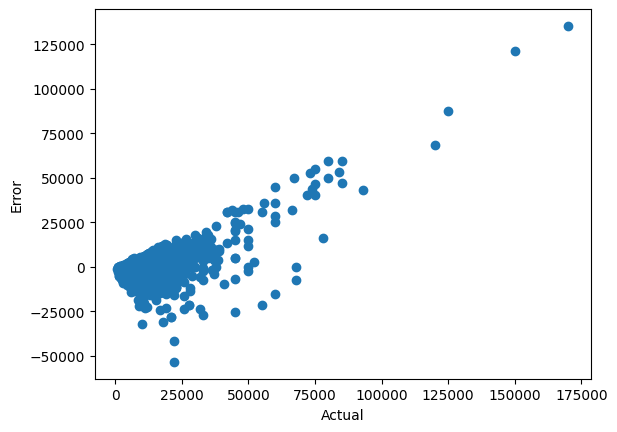

In [23]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25', 'noOfBedRoom']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

parameters = {
    'n_neighbors': np.arange(1, 15, 1),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
}
cv = GridSearchCV(estimator = KNeighborsRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 10,
                           verbose=0)
cv.fit(X_train_scaled, y_train)

pprint("Tuned Hyperparameters:")
pprint(cv.best_params_)
model = KNeighborsRegressor(n_neighbors=cv.best_params_["n_neighbors"], 
                              weights=cv.best_params_["weights"],
                              metric="euclidean")
model.fit(X_train_scaled, y_train)

print(f"training r2: {model.score(X_train_scaled, y_train)}")
print(f"testing r2: {model.score(X_test_scaled, y_test)}")
pred = model.predict(X_test_scaled)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test_scaled, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()

### Feature Selection (Shapley)

In [14]:
import shap
# Produce the SHAP values
knn_explainer = shap.KernelExplainer(model.predict, shap.sample(X_test_scaled))
knn_shap_values = knn_explainer.shap_values(X_test_scaled.sample(50))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [09:54<00:00, 11.90s/it]


In [24]:
feature_importance = np.abs(knn_shap_values).mean(axis=0)
importances = np.abs(knn_shap_values).mean(axis=0)
feature_names = list(X_train_scaled.columns)

# Create a list of (feature name, importance) tuples
feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=False)
feature_impt_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance")
feature_impt_df

,Feature,Importance
3,district_2,0.000000
4,district_3,0.000000
18,district_18,0.000000
7,district_7,0.000000
8,district_8,0.000000
24,district_25,11.923215
25,district_26,25.956379
17,district_17,27.612188
12,district_12,28.987785
23,district_23,40.068485


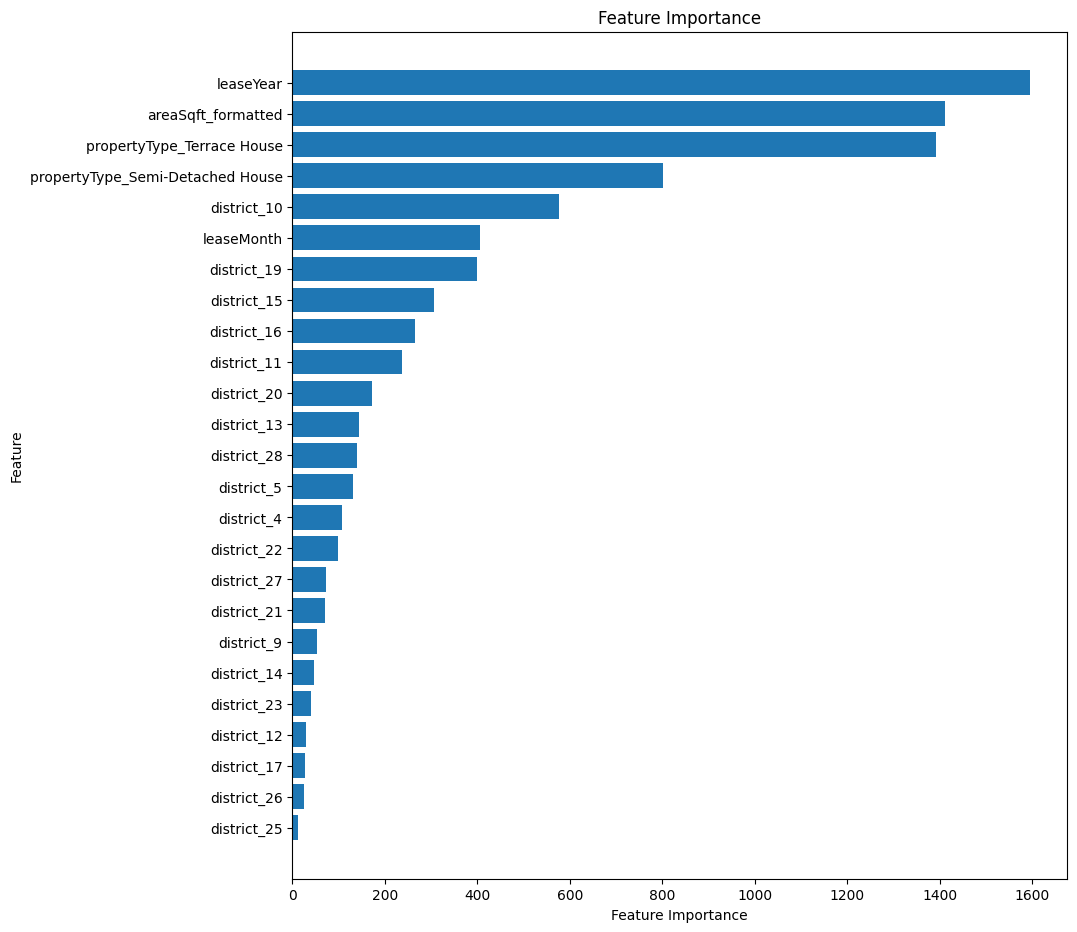

In [25]:
# Plot feature importances
nonzero_feature_importances = feature_impt_df[feature_impt_df["Importance"] != 0]
plt.figure(figsize=(10, 11))
plt.barh(nonzero_feature_importances["Feature"], nonzero_feature_importances["Importance"], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Run on Selected Features

In [18]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

1                            leaseYear
0                   areaSqft_formatted
29          propertyType_Terrace House
28    propertyType_Semi-Detached House
10                         district_10
2                           leaseMonth
19                         district_19
15                         district_15
16                         district_16
11                         district_11
20                         district_20
13                         district_13
27                         district_28
6                           district_5
5                           district_4
22                         district_22
26                         district_27
21                         district_21
9                           district_9
14                         district_14
23                         district_23
12                         district_12
17                         district_17
25                         district_26
24                         district_25
Name: Feature, dtype: obj

{'n_neighbors': 14, 'weights': 'distance'}
training r2: 0.7239865918970105
testing r2: 0.4904605590676564

score   = 0.4904605590676564
r2      = 0.4904605590676564
MAE     = 2876.672818779938
RMSE    = 6409.5577002703385
MSE     = 41082429.913094796
MAE %   = 0.3036643938662699



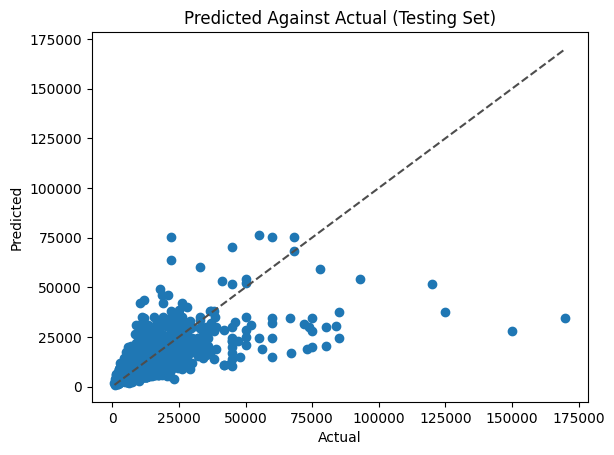

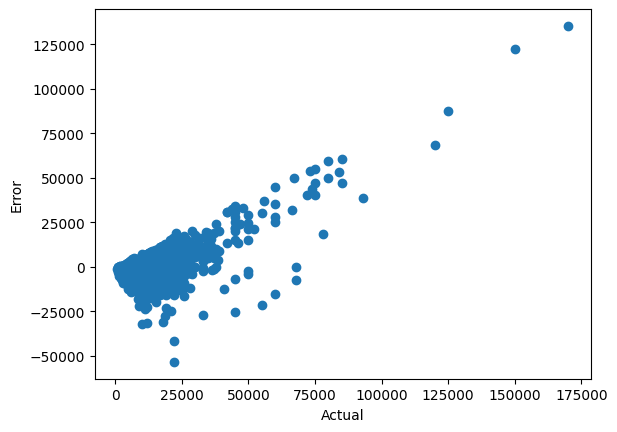

In [26]:
selected_features = [
                       "leaseYear",
              "areaSqft_formatted",
      "propertyType_Terrace House",
"propertyType_Semi-Detached House",
                     "district_10",
                      "leaseMonth",
                     "district_19",
                     "district_15",
                     "district_16",
                     "district_11",]

select_X_train = X_train_scaled[selected_features]
select_X_test = X_test_scaled[selected_features]

# Define the hyperparameters grid for grid search
param_grid = {'n_neighbors': np.arange(2, 15, 1),
            'weights' : ['uniform', 'distance'],}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator = KNeighborsRegressor(),  
                        param_grid = param_grid,
                        scoring = 'neg_mean_absolute_error',
                        cv = 10,
                        verbose=0)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = KNeighborsRegressor(n_neighbors=best_params["n_neighbors"], 
                              weights=best_params["weights"],
                              metric="euclidean")
model.fit(select_X_train, y_train)

print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()

## Non-Landed

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseMonth', 'district_2', 'district_3', 'district_4', 'district_5', 'district_6', 'district_7', 'district_8', 'district_9', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']
'Tuned Hyperparameters:'
{'n_neighbors': 14, 'weights': 'uniform'}
training r2: 0.7482772135903711
testing r2: 0.731362307114451

score   = 0.731362307114451
r2      = 0.731362307114451
MAE     = 732.3389376391618
RMSE    = 1426.153331580812
MSE     = 2033913.325179049
MAE %   = 0.15796649393133164



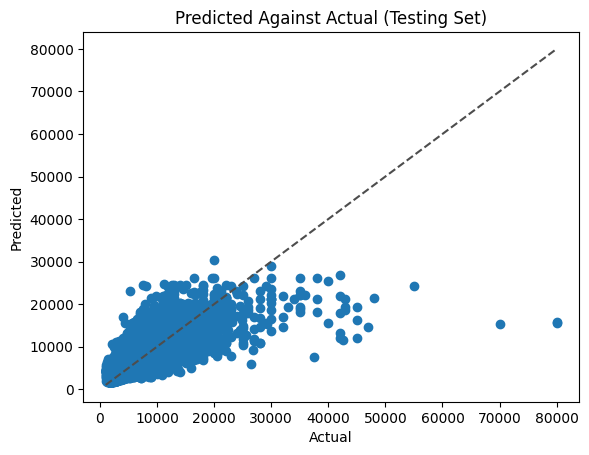

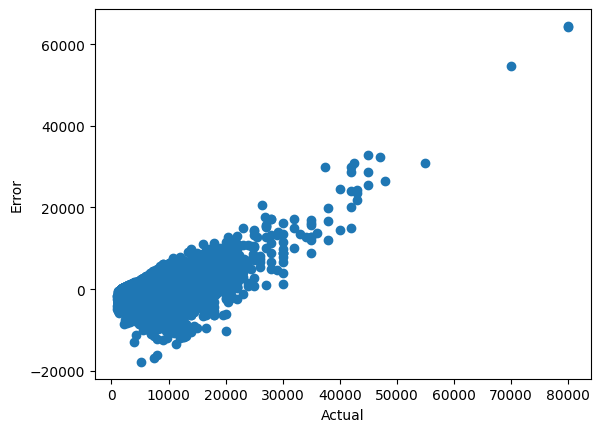

In [27]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25', ]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], nonlanded_encoded["rent"], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

parameters = {
    'n_neighbors': np.arange(1, 15, 1),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
}
cv = GridSearchCV(estimator = KNeighborsRegressor(),  
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 10,
                           verbose=0)
cv.fit(X_train_scaled, y_train)

pprint("Tuned Hyperparameters:")
pprint(cv.best_params_)
model = KNeighborsRegressor(n_neighbors=cv.best_params_["n_neighbors"], 
                              weights=cv.best_params_["weights"],
                              metric="euclidean")
model.fit(X_train_scaled, y_train)

print(f"training r2: {model.score(X_train_scaled, y_train)}")
print(f"testing r2: {model.score(X_test_scaled, y_test)}")
pred = model.predict(X_test_scaled)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(X_test_scaled, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()

### Feature Selection (Shapley)

In [28]:
import shap
# Produce the SHAP values
knn_explainer = shap.KernelExplainer(model.predict, shap.sample(X_test_scaled))
knn_shap_values = knn_explainer.shap_values(X_test_scaled.sample(50))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [10:50:55<00:00, 781.10s/it]   


In [29]:
feature_importance = np.abs(knn_shap_values).mean(axis=0)
importances = np.abs(knn_shap_values).mean(axis=0)
feature_names = list(X_train_scaled.columns)

# Create a list of (feature name, importance) tuples
feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=False)
feature_impt_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance")
feature_impt_df

,Feature,Importance
19,district_17,0.000000
29,district_28,0.000000
8,district_6,0.000000
9,district_7,7.421179
4,district_2,10.338659
26,district_25,11.457928
30,propertyType_Non-landed Properties,11.658594
28,district_27,22.394045
22,district_20,25.862416
5,district_3,26.669003


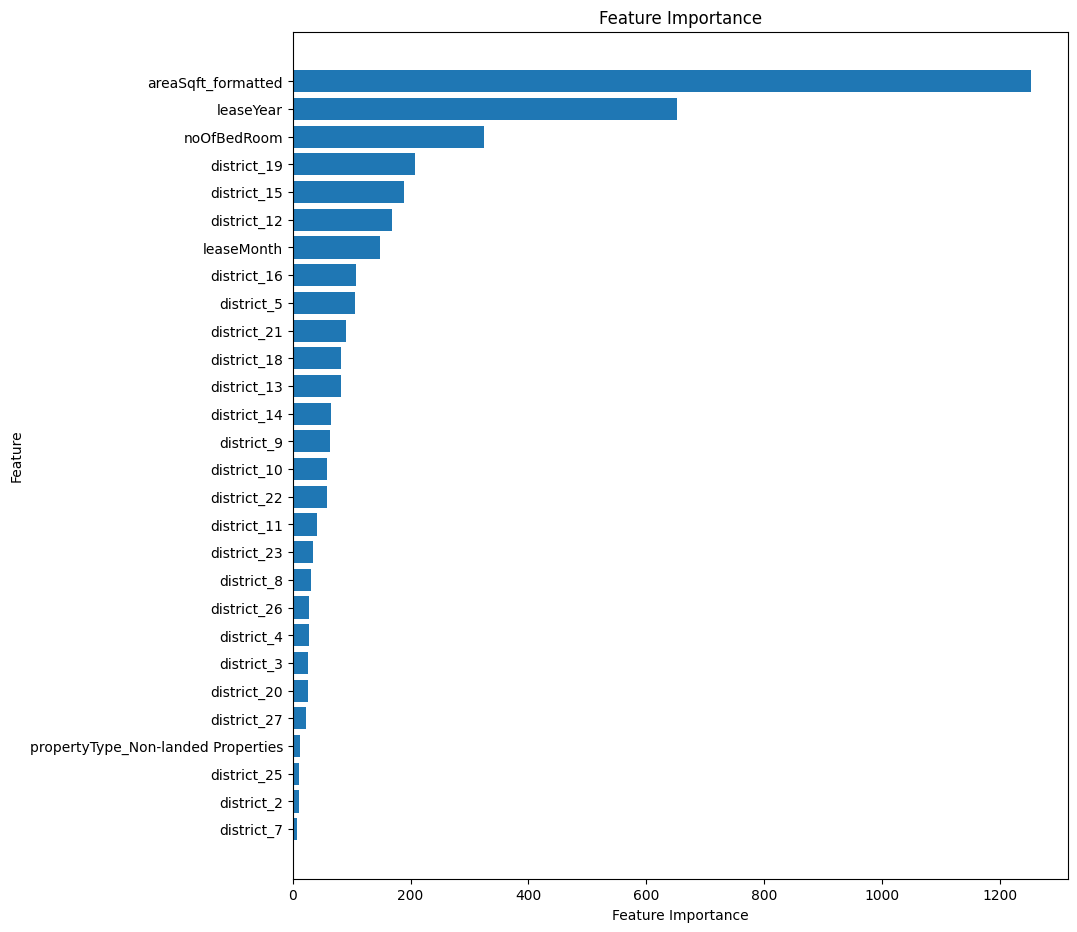

In [30]:
# Plot feature importances
nonzero_feature_importances = feature_impt_df[feature_impt_df["Importance"] != 0]
plt.figure(figsize=(10, 11))
plt.barh(nonzero_feature_importances["Feature"], nonzero_feature_importances["Importance"], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Run on Selected Features

In [31]:
nonzero_feature_importances.sort_values("Importance", ascending=False)["Feature"]

1                     areaSqft_formatted
2                              leaseYear
0                            noOfBedRoom
21                           district_19
17                           district_15
14                           district_12
3                             leaseMonth
18                           district_16
7                             district_5
23                           district_21
20                           district_18
15                           district_13
16                           district_14
11                            district_9
12                           district_10
24                           district_22
13                           district_11
25                           district_23
10                            district_8
27                           district_26
6                             district_4
5                             district_3
22                           district_20
28                           district_27
30    propertyTy

{'n_neighbors': 14, 'weights': 'uniform'}
training r2: 0.6318649923136193
testing r2: 0.6118808324006346

score   = 0.6118808324006346
r2      = 0.6118808324006346
MAE     = 985.1314944390041
RMSE    = 1714.215003647283
MSE     = 2938533.0787294544
MAE %   = 0.22048312291885222



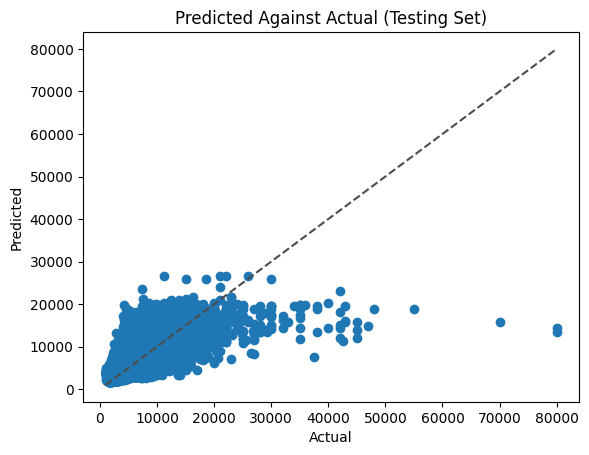

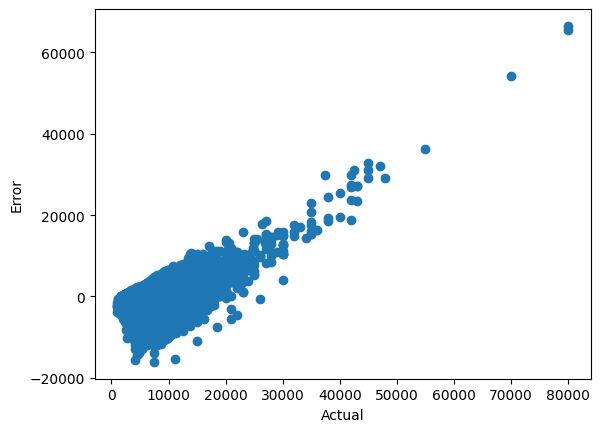

In [32]:
selected_features = [
    "areaSqft_formatted",
             "leaseYear",
           "noOfBedRoom",
           "district_19",
           "district_15",
           "district_12",
            "leaseMonth",]

select_X_train = X_train_scaled[selected_features]
select_X_test = X_test_scaled[selected_features]

# Define the hyperparameters grid for grid search
param_grid = {'n_neighbors': np.arange(2, 15, 1),
            'weights' : ['uniform', 'distance'],}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator = KNeighborsRegressor(),  
                        param_grid = param_grid,
                        scoring = 'neg_mean_absolute_error',
                        cv = 10,
                        verbose=0)

# Fit the grid search to the training data
grid_search.fit(select_X_train, y_train)

# Get the best model and its hyperparameters
selection_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
model = KNeighborsRegressor(n_neighbors=best_params["n_neighbors"], 
                              weights=best_params["weights"],
                              metric="euclidean")
model.fit(select_X_train, y_train)

print(f"training r2: {model.score(select_X_train, y_train)}")
print(f"testing r2: {model.score(select_X_test, y_test)}")
pred = model.predict(select_X_test)
results = pd.DataFrame({"true_values": y_test, "predictions": pred})
results["error"] = results["true_values"] - results["predictions"]
print(f"""
score   = {model.score(select_X_test, y_test)}
r2      = {r2_score(y_test, pred)}
MAE     = {mean_absolute_error(y_test, pred)}
RMSE    = {mean_squared_error(y_test, pred, squared=False)}
MSE     = {mean_squared_error(y_test, pred)}
MAE %   = {mean_absolute_percentage_error(y_test, pred)}
""")

diag_line_lower, diag_line_upper = min(min(y_test), min(pred)), max(max(y_test), max(pred))
plt.scatter(y_test, pred)
plt.plot([diag_line_lower, diag_line_upper], [diag_line_lower, diag_line_upper], ls="--", c=".3")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title(f'K={cv.best_params_["n_neighbors"]}, {cv.best_params_["weights"]} weights')
plt.title("Predicted Against Actual (Testing Set)")
plt.show()

plt.scatter(results["true_values"], results["error"])
plt.xlabel("Actual")
plt.ylabel("Error")
plt.show()